# **Machine Leraning for Medicine**
# **Bayesian Networks for Clinical Data Analysis.**
* Student : Aymen MERROUCHE.

In [1]:
import pandas as pd
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn2graph as bnPlot
import pyAgrum.lib.dynamicBN as gdyn

# 1 - Modeling With a Bayesian Network :
> In this section we model with a Bayesian Network the problem of type 2 diabetes remission after a gastric by-pass surgery.

In [29]:
# Fast way to create the DAG
dr = gum.fastBN("Remission<-Insulin<-Glycemia->Other_drugs->Remission")
dr

(gum::BayesNet<double>@0x2f30310) BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}

In [3]:
# Add marginal for Glycemia and CPTs for other varaibles :

# Marginal for Glycemia (Glycemia > 6.5)
dr.cpt("Glycemia")[:] = [0.5, 0.5]

# CPT for Insulin
dr.cpt("Insulin")[:]=[[0.9,0.1],[0.1,0.9]]
# Equivalent to 
#dr.cpt("Insulin")[{"Glycemia":0}] = [0.9,0.1] 
#dr.cpt("Insulin")[{"Glycemia":1}] = [0.9,0.1] 

# CPT for Other_drugs
dr.cpt("Other_drugs")[:]=[[0.7,0.3],[0.25,0.75]]

# CPT for Remission
dr.cpt("Remission")[{"Insulin":1,"Other_drugs":1}] = [0.9, 0.1] # a=0,b=0
dr.cpt("Remission")[{"Insulin":0,"Other_drugs":1}] = [0.4, 0.6] # a=0,b=1
dr.cpt("Remission")[{"Insulin":1,"Other_drugs":0}] = [0.7, 0.3] # a=1,b=0
dr.cpt("Remission")[{"Insulin":0,"Other_drugs":0}] = [0.1, 0.9] # a=1,b=1

In [4]:
# display the network with CPT tables
gnb.sideBySide(dr,
               dr.cpt("Glycemia"),
               dr.cpt("Insulin"),
               dr.cpt("Other_drugs"),
               dr.cpt("Remission"),
               captions=["the BN","the marginal for $Glycemia$","the CPT for $Insulin$","the CPT for $Other\_drugs$","the CPT for $Remission$"])

## 1 - 1 - Inference :

In [5]:
# define the inference engine (LazyPropagation : exact inference)
ie=gum.LazyPropagation(dr)

In [6]:
# infer
ie.makeInference()
# display posterior of Remission
ie.posterior("Remission")

(gum::Potential<double>@0x2856e70) 
  Remission        |
0        |1        |
---------|---------|
 0.5223  | 0.4778  |

## 1 - 2 - Answering Some Observational Queries :

### **What is the probability to get the remission if the glycemia level is less than 6.5 and no drugs are taken?**
> We are interested in the distribution of the variable $Remission$ if we know that the variable $Glycemia$ is less than $6.5$ (No = $0$) and the no drugs were taken (the variable $Other\_drugs$ is equal to $0$). In other words :
$$P(Remission | Glycemia = 0, Other\_drugs = 0)$$

In [7]:
# set the evidence
evs = {'Glycemia' : 0, 'Other_drugs' : 0}
ie.setEvidence(evs)
# infer
ie.makeInference()
# display results
gnb.sideBySide(ie.posterior("Remission"),gnb.getInference(dr, evs = evs),
              captions=["$P(Remission | Glycemia = 0, Other\_drugs = 0)$","Complete inference with evidence="+str(evs)])

> If the $Glycemia$ level is less than $6.5$ and the no drugs were taken we have a remission probability $0.84$.

### **What is the probability to get the remission if the glycemia level is bigger than 6.5 and insulin is prescribed?**
> We are interested in the distribution of the variable $Remission$ if we know that the variable $Glycemia$ is bigger than $6.5$ (No = $1$) and that insulin was prescribed (the variable $Other\_drugs$ is equal to $1$). In other words :
$$P(Remission | Glycemia = 1, Other\_drugs = 1)$$

In [8]:
# set the evidence
evs = {'Glycemia' : 1, 'Other_drugs' : 1}
ie.setEvidence(evs)
# infer
ie.makeInference()
# display results
gnb.sideBySide(ie.posterior("Remission"),gnb.getInference(dr, evs = evs),
              captions=["$P(Remission | Glycemia = 1, Other\_drugs = 1)$","Complete inference with evidence="+str(evs)])

> If the $Glycemia$ is bigger than $6.5$ and insulin was prescribed we have a remission probability of $0.15$.

> **REMARK :** In this section we answered some observational queries (consist of finding variables that are associated by collecting and analyzing raw data. It allows us to answer queries based on passive observation of data **If I observe variable $ X $, what can I say about variable $ Y $? (i.e $ P (Y \mid X) $)**). In order to answer interventional queries (consist of predicting the effect of a deliberate intervention,**What would $ X $ be, if I do $ Y $? (i.e. $P(X \mid do(Y))$)**, interventional queries can not be answered using only passively collected data) or counterfactual queries (consists of reasoning about hypothetical situations, **What would have happened if?**), the network needs to become a causal diagram ($A \rightarrow B$ means that $A$ causes $B$, which is not always the case).

# 2 - Bayesian Network from Real Data :
> In this section we create a network from real data (CPTs and Marginals are computed from the data). Two heuristic search approaches methods are tested for learning the structure of bayesian networks namely **Hill Climbing** and **Tabu Search** :
> * Hill Climbing : a simple iterative technique.
>* Tabu Search : a memory based approach that guides a local heuristic search procedure to explore the solution space beyond local optimality.

Generally speaking, Tabu search yields better results because of amnesy of hill climbing, source :
[Learning the structure of Bayesian Networks:  Aquantitative assessment of the effect of differentalgorithmic schemes](https://arxiv.org/pdf/1704.08676.pdf)

In [9]:
# path to data
data_path = "./data/SPLEX/"

In [10]:
# utilitary function to discretize the data (BN can be constructed only from discrete data)
def discretize_dataset(dataframe, ignore = [], path_to_save = "./", name_to_save = "discr_data", num_bins = 5):
    """
    Discretise a dataset (of continuous variables). This function is based on the numpy.digitize function. Given a fixed number of bins, this function
    creates for each column (variable in the data set) that number of bins. Then, for every value of a variable of a data-point, it returns the index
    of the bin to which this value belongs.
    :param dataframe: the dataset (expected to be a pandas dataframe)
    :param ignore: list of columns to ignore (no discretizing for these columns)
    :param path_to_save: the path to where to store the resulting data set (saved as .csv), defaults current directory.
    :param name_to_save: the name to give to the resulting dataset, defaults discr_data.csv.
    :param num_bins: the number of discretisation bins to use (fixed for all variables), defaults 5.
    """
    l=[]
    for col in list(set(dataframe.columns.values) - set(ignore)):
        bins = np.linspace(min(dataframe[col]), max(dataframe[col]), num_bins)
        l.append(pd.DataFrame(np.digitize(dataframe[col], bins),columns=[col]))
    # add the ignored columns to the dataframe
    for c in ignore:
        l.append(pd.DataFrame(dataframe[[c]])) 
    discr_data=pd.concat(l, join='outer', axis=1)
    discr_data.to_csv(path_to_save+name_to_save+".csv",index=False)

## 2 - 1 - Network for Host Varaibles :

In [11]:
# SPLEX host dataset, load and display some information about the data
splex_host = pd.read_table(data_path+"SPLEX_host.txt", sep=" ")
print("Number of examples :", splex_host.shape[0])
print("Dimension of the problem :", splex_host.shape[1])
print("Variables : ", splex_host.columns.values)
print("Sample of the data :")
splex_host.head()

Number of examples : 49
Dimension of the problem : 45
Variables :  ['Sexe' 'Age' 'cBMI_corp' 'cTT_corp' 'cTH_corp' 'cWHR' 'cMGkg_corp'
 'cMGpourc_corp' 'cMMkg_corp' 'cMMpourc_corp' 'cAndpourc_corp'
 'cGynpourc_corp' 'cGly_meta' 'cIns_meta' 'cHOMA_B_meta' 'cHOMA_S_meta'
 'cHOMA_IR_meta' 'cDisse_meta' 'cQUICKI_meta' 'crevised_QUICKI_meta'
 'cIGR_meta' 'cFIRI_clin' 'cChol_meta' 'cTG_meta' 'cHDL_meta' 'cLDL_meta'
 'cNHDL' 'cAGL_meta' 'cCreatine_rein' 'cCystatineC_rein' 'cDiam_corp'
 'cHAM56pourc_infl' 'cCD163pourc_infl' 'cCD40pourc_infl' 'cCRP_inf'
 'cIL6_inf' 'cLPS_inf' 'cvegf_inf' 'ceotaxin_inf' 'cip10_inf' 'cmcp1_inf'
 'cmip1b_inf' 'cCD14_infl' 'cLeptin_meta' 'cAdipo_meta']
Sample of the data :


,Sexe,Age,cBMI_corp,cTT_corp,cTH_corp,cWHR,cMGkg_corp,cMGpourc_corp,cMMkg_corp,cMMpourc_corp,...,cIL6_inf,cLPS_inf,cvegf_inf,ceotaxin_inf,cip10_inf,cmcp1_inf,cmip1b_inf,cCD14_infl,cLeptin_meta,cAdipo_meta
0,2,41,-0.93755,5.0,-1.0,0.05389,-2.53,-1.66,-0.31,1.78,...,25,33,28,34,16,23,13,14,47,5
1,1,50,-2.54899,-9.0,-5.0,-0.04326,-2.69,-1.34,-1.99,1.01,...,23,22,13,6,2,3,43,12,21,27
2,1,56,-1.23884,0.0,1.0,-0.00787,0.33,0.73,-1.22,-0.87,...,15,21,48,37,36,48,47,15,9,18
3,1,34,-2.90913,-15.0,-6.0,-0.07791,-2.82,0.33,-3.77,-0.53,...,35,31,6,1,21,49,10,44,33,29
4,1,56,-2.47137,-11.0,-4.0,-0.07015,-3.97,-1.97,-2.47,1.62,...,14,14,27,24,15,13,20,20,17,21


In [12]:
# discretize the dataset, save and the load the discretized dataset :
path_to_save = data_path
name_to_save = "SPLEX_host_disc"
discretize_dataset(splex_host, path_to_save = path_to_save, name_to_save = name_to_save, num_bins = 5)
discr_splex_host = pd.read_table(path_to_save+name_to_save+".csv", sep=",")
print("Sample of the discretised host data :")
discr_splex_host.head()

Sample of the discretised host data :


,cHOMA_S_meta,cTH_corp,cMGpourc_corp,ceotaxin_inf,cCD40pourc_infl,cLDL_meta,cHOMA_IR_meta,cHOMA_B_meta,cAndpourc_corp,cGynpourc_corp,...,cCreatine_rein,Age,cmcp1_inf,cIGR_meta,cMMpourc_corp,cTG_meta,cIL6_inf,cCRP_inf,cCD163pourc_infl,cCD14_infl
0,1,4,2,3,1,2,4,3,4,4,...,1,2,2,3,3,2,3,3,2,2
1,1,3,2,1,1,1,4,4,3,4,...,2,3,1,3,3,3,2,3,1,1
2,1,4,3,4,5,2,4,3,3,4,...,1,4,4,4,2,3,2,3,4,2
3,1,3,3,1,2,2,4,3,4,3,...,1,2,5,3,2,3,3,3,1,4
4,2,3,2,2,3,1,4,3,3,4,...,2,4,2,3,3,3,2,3,1,2


In [13]:
# Learn the Bayesian Network for host variables, and save the obtained networks

# path to discretised dataset
data_where = "./data/SPLEX/SPLEX_host_disc.csv"
# declare learner
learner=gum.BNLearner(data_where)
# leran the BN
# learn the BN with useLocalSearchWithTabuList
learner.useLocalSearchWithTabuList()
host_bn_local = learner.learnBN()
# learn the BN with useGreedyHillClimbing()
learner.useGreedyHillClimbing()
host_bn_greedy = learner.learnBN()

In [14]:
gnb.sideBySide(host_bn_local,
               host_bn_greedy,
               captions=["BN when using useLocalSearchWithTabuList","BN when using useGreedyHillClimbing"])

BN when using useLocalSearchWithTabuList,BN when using useGreedyHillClimbing


In [15]:
# example of a CPT table
gnb.sideBySide(host_bn_local.cpt("crevised_QUICKI_meta"),
               host_bn_greedy.cpt("crevised_QUICKI_meta"),
               captions=["CPT for $crevised\_QUICKI\_meta$ when using useLocalSearchWithTabuList","CPT for $crevised\_QUICKI\_meta$ when using useGreedyHillClimbing"])

In [16]:
# save BNs images as pdf
path_to_save = "./data/SPLEX/BN/"
bnPlot.dotize(host_bn_greedy, path_to_save+"host_bn_greedy", format='pdf')
bnPlot.dotize(host_bn_local, path_to_save+"host_bn_local", format='pdf')

> Let's remark that we do not get the same Bayesian Network when using the useLocalSearchWithTabuList function and the useGreedyHillClimbing function.

## 2 - 1 - Network for Environmental Varaibles :

In [17]:
# SPLEX env dataset
data_path = "./data/SPLEX/"
splex_env = pd.read_table(data_path+"SPLEX_env.txt", sep=" ")
print("Number of examples :", splex_env.shape[0])
print("Dimension of the problem :", splex_env.shape[1])
print("Variables : ", splex_env.columns.values)
print("Sample of the data :")
splex_env.head()

Number of examples : 49
Dimension of the problem : 63
Variables :  ['cWI_ap' 'cSI_ap' 'cLI_ap' 'Food_intake_alim' 'Water_alim' 'Pr_alim'
 'Prpourc_alim' 'CHO_alim' 'CHOpourc_alim' 'Sugar_alim' 'Amidon_alim'
 'Fiber_alim' 'Lipid_alim' 'Lippourc_alim' 'SaturedLip_alim'
 'MonoSLip_alim' 'PolyinSLip_alim' 'Chol_alim' 'Alcohol_alim'
 'Sodium_alim' 'K_alim' 'Mg_alim' 'Ph_alim' 'Ca_alim' 'Fe_alim'
 'VitA_alim' 'Betacarotene_alim' 'VitB1_alim' 'VitB2_alim' 'VitB3_alim'
 'VitB5_alim' 'VitB6_alim' 'VitB9_alim' 'VitB12_alim' 'VitC_alim'
 'VitD_alim' 'VitE_alim' 'aperitifs_tartes_salees_pizzas'
 'boissons_alcoolisees' 'boissons_non_sucrees_sans_alcool'
 'boissons_sucrees_sans_alcool' 'cereales' 'cereales_du_petit_dejeuner'
 'charcuterie' 'corps_gras' 'eau' 'fromage' 'fruits' 'lait' 'legumes'
 'legumineuses' 'Noix_graines' 'oeufs' 'pain_et_produits_panifies'
 'produits_aquatiques' 'produits_sucres' 'sauces_et_condiments' 'Soupes'
 'tubercules' 'viande_blanche' 'viande_rouge'
 'viennoiseries_patisse

,cWI_ap,cSI_ap,cLI_ap,Food_intake_alim,Water_alim,Pr_alim,Prpourc_alim,CHO_alim,CHOpourc_alim,Sugar_alim,...,pain_et_produits_panifies,produits_aquatiques,produits_sucres,sauces_et_condiments,Soupes,tubercules,viande_blanche,viande_rouge,viennoiseries_patisseries_biscui,yaourt_fromage_blanc
0,12,8,2,44,33,15,3,43,39,43,...,17,40,18,2,19,39,19,2,43,36
1,1,7,1,18,37,43,22,29,27,42,...,2,28,27,4,4,15,36,4,30,13
2,7,12,14,21,20,25,10,32,33,19,...,5,11,38,19,38,22,30,31,36,14
3,11,2,7,23,43,28,20,31,29,1,...,42,30,42,28,28,15,2,33,10,41
4,11,11,2,3,1,45,30,9,30,16,...,3,21,15,2,5,2,22,2,27,11


In [18]:
# discretize the dataset, save and the load the discretized dataset :
path_to_save = './data/SPLEX/'
name_to_save = "SPLEX_env_disc"
discretize_dataset(splex_env, path_to_save = path_to_save, name_to_save = name_to_save, num_bins = 5)
discr_splex_env = pd.read_table(path_to_save+name_to_save+".csv", sep=",")
print("Sample of the discretised enviromental data :")
discr_splex_env.head()

Sample of the discretised enviromental data :


,pain_et_produits_panifies,Alcohol_alim,K_alim,boissons_non_sucrees_sans_alcool,Fiber_alim,Betacarotene_alim,VitA_alim,CHOpourc_alim,Pr_alim,CHO_alim,...,produits_aquatiques,VitD_alim,Chol_alim,tubercules,viande_blanche,viande_rouge,fruits,sauces_et_condiments,PolyinSLip_alim,Sugar_alim
0,2,1,4,1,2,2,1,4,2,4,...,5,4,1,5,2,1,4,1,4,4
1,1,4,3,3,4,1,3,3,4,3,...,3,3,1,2,4,1,1,1,1,4
2,1,4,1,3,4,1,3,3,3,3,...,2,1,4,3,3,3,1,3,3,2
3,5,3,4,4,3,4,1,3,3,3,...,3,1,1,2,1,4,3,4,2,1
4,1,4,2,3,1,4,3,3,5,1,...,3,4,3,1,3,1,1,1,3,2


In [19]:
# Learn the Bayesian Network for host variables, and save the obtained networks

# path to discretised dataset
data_where = "./data/SPLEX/SPLEX_env_disc.csv"
# declare learner
learner=gum.BNLearner(data_where)
# leran the BN
# learn the BN with useLocalSearchWithTabuList
learner.useLocalSearchWithTabuList()
env_bn_local = learner.learnBN()
# learn the BN with useGreedyHillClimbing()
learner.useGreedyHillClimbing()
env_bn_greedy = learner.learnBN()

In [20]:
gnb.sideBySide(env_bn_local,
               env_bn_greedy,
               captions=["BN when using useLocalSearchWithTabuList","BN when using useGreedyHillClimbing"])

BN when using useLocalSearchWithTabuList,BN when using useGreedyHillClimbing


In [21]:
# example of a CPT table
gnb.sideBySide(env_bn_local.cpt("Mg_alim"),
               env_bn_greedy.cpt("Mg_alim"),
               captions=["CPT for $Mg\_alim$ when using useLocalSearchWithTabuList","CPT for $Mg\_alim$ when using useGreedyHillClimbing"])

In [22]:
# save BN images as pdf
path_to_save = "./data/SPLEX/BN/"
bnPlot.dotize(env_bn_greedy, path_to_save+"env_bn_greedy", format='pdf')
bnPlot.dotize(env_bn_local, path_to_save+"env_bn_local", format='pdf')

> Let's remark that we do not get the same Bayesian Network when using the useLocalSearchWithTabuList function and the useGreedyHillClimbing function.

# 3 - Dynamic Bayesian Networks :
> In this section we build a dynamic BN which allows to see the evolution of different variables across time steps.

In [23]:
# load the dynamic.txt data set and display some information
data_path = "./data/"
dynamic = pd.read_table(data_path+"dynamic.txt", sep=" ")
print("Number of examples :", dynamic.shape[0])
print("Dimension of the problem :", dynamic.shape[1])
print("Variables : ", dynamic.columns.values)
print("Sample of the data :")
dynamic.head()

Number of examples : 175
Dimension of the problem : 12
Variables :  ['HbA1C0' 'HbA1C1' 'HbA1C2' 'Gly0' 'Gly1' 'Gly2' 'Poids0' 'Poids1'
 'Poids2' 'Status0' 'Status1' 'Status2']
Sample of the data :


,HbA1C0,HbA1C1,HbA1C2,Gly0,Gly1,Gly2,Poids0,Poids1,Poids2,Status0,Status1,Status2
0,6.7,5.9,6.1,6.105,4.7,5.0,110.7,67.0,72.0,1,1,3
1,6.0,5.2,5.2,6.327,4.0,4.9,177.0,127.0,143.6,1,1,1
2,6.8,5.9,6.6,7.881,6.0,6.4,133.4,110.0,115.0,1,3,2
3,9.4,7.7,8.4,11.700,9.1,7.9,95.2,80.0,85.1,1,2,2
4,8.0,5.7,5.9,10.700,5.4,5.6,120.0,92.1,84.7,1,1,3


In [24]:
# discretise the dataset
path_to_save = './data/'
name_to_save = "dynamic_disc"
discretize_dataset(dynamic, ignore=["Status0", "Status1", "Status2"] , path_to_save = path_to_save, name_to_save = name_to_save, num_bins = 5)
discr_dynamic = pd.read_table(path_to_save+name_to_save+".csv", sep=",")
print("Sample of the discretised dynamic dataset :")
discr_dynamic.head()

Sample of the discretised dynamic dataset :


,HbA1C0,Poids1,Gly1,HbA1C2,Gly0,Gly2,Poids0,HbA1C1,Poids2,Status0,Status1,Status2
0,1,1,1,1,1,1,1,2,1,1,1,3
1,1,3,1,1,1,1,4,2,3,1,1,1
2,1,2,2,2,2,1,2,2,2,1,3,2
3,2,1,4,3,3,2,1,4,1,1,2,2
4,1,2,2,1,2,1,2,2,1,1,1,3


In [25]:
# learn the dynamic BN : a variable with a name A is present at t=0 with the name A0 and at time t as At.

# path to discretised dataset
data_where = "./data/dynamic_disc.csv"
# declare learner
learner=gum.BNLearner(data_where)
# leran the BN
# learn the BN with useLocalSearchWithTabuList
learner.useLocalSearchWithTabuList()
dynamic_bn_local = learner.learnBN()
# learn the BN with useGreedyHillClimbing()
learner.useGreedyHillClimbing()
dynamic_bn_greedy = learner.learnBN()

In [26]:
# display the leanrned dynamic BNs
gnb.sideBySide(dynamic_bn_local,
               dynamic_bn_greedy,
               captions=["BN when using useLocalSearchWithTabuList","BN when using useGreedyHillClimbing"])

BN when using useLocalSearchWithTabuList,BN when using useGreedyHillClimbing


> Note that we do not get the same Bayesian Network when using the useLocalSearchWithTabuList function and the useGreedyHillClimbing function.

### **Visualize the Network with Time Slices :**

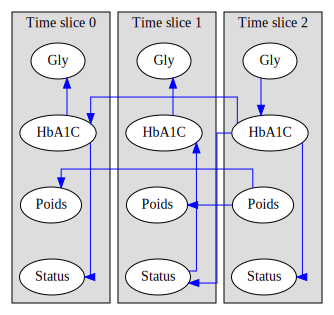

In [27]:
# visualize the network with time slices
gdyn.showTimeSlices(dynamic_bn_local)

> We can see the interactions between the different variables across time.

### **Inference for Variable Status : remission,non-remission, or partial remission :**

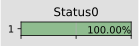

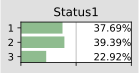

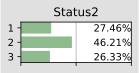

In [28]:
# Inference (Status : remission,non-remission, or partial remission)
for i in range(3):
    gnb.showPosterior(dynamic_bn_local,target="Status{}".format(i),evs={})

> After recording the different variables and building the BN, we infer the variable status (across time steps) and see how it evoloves (from 1, to approximately equal distribution to 2).